## Импортируем необходимые библиотеки

In [2]:
import pandas as pd
import sqlite3

## Создадим подключение к базе данных

In [3]:
conn = sqlite3.connect("../data/checking-logs.sqlite")

## Сделаем запрос к базе данных, анализируем только users

In [4]:
query = """
SELECT timestamp AS datetime
FROM checker
WHERE checker.uid LIKE 'user_%';
"""
df_datetime = pd.read_sql_query(query, conn)


## Извлечем дату и час коммита

In [5]:
df_datetime["datetime"] = pd.to_datetime(df_datetime["datetime"])
df_datetime["date"] = df_datetime["datetime"].dt.date
df_datetime["hour"] = df_datetime["datetime"].dt.hour
df_datetime.head()

,datetime,date,hour
0,2020-04-17 05:19:02.744528,2020-04-17,5
1,2020-04-17 05:22:35.249331,2020-04-17,5
2,2020-04-17 05:22:45.549397,2020-04-17,5
3,2020-04-17 05:34:14.691200,2020-04-17,5
4,2020-04-17 05:34:24.422370,2020-04-17,5


## Определим время суток

In [6]:
df_datetime["daytime"] = pd.cut(df_datetime["hour"], bins=[0, 4, 10, 17, 24], labels=["night", "morning", "afternoon", "evening"], right=False)
df_datetime.head()

,datetime,date,hour,daytime
0,2020-04-17 05:19:02.744528,2020-04-17,5,morning
1,2020-04-17 05:22:35.249331,2020-04-17,5,morning
2,2020-04-17 05:22:45.549397,2020-04-17,5,morning
3,2020-04-17 05:34:14.691200,2020-04-17,5,morning
4,2020-04-17 05:34:24.422370,2020-04-17,5,morning


## Сгруппируем коммиты по времени суток и посчитаем их количество

In [7]:
res_df = df_datetime.groupby([df_datetime["date"], "daytime"]).size().unstack(fill_value=0)
res_df.head()

daytime,night,morning,afternoon,evening
date,,,,
2020-04-17,0,13,10,0
2020-04-18,0,1,33,35
2020-04-19,2,4,16,11
2020-04-20,0,0,12,13
2020-04-21,0,0,0,25


## Создадим график

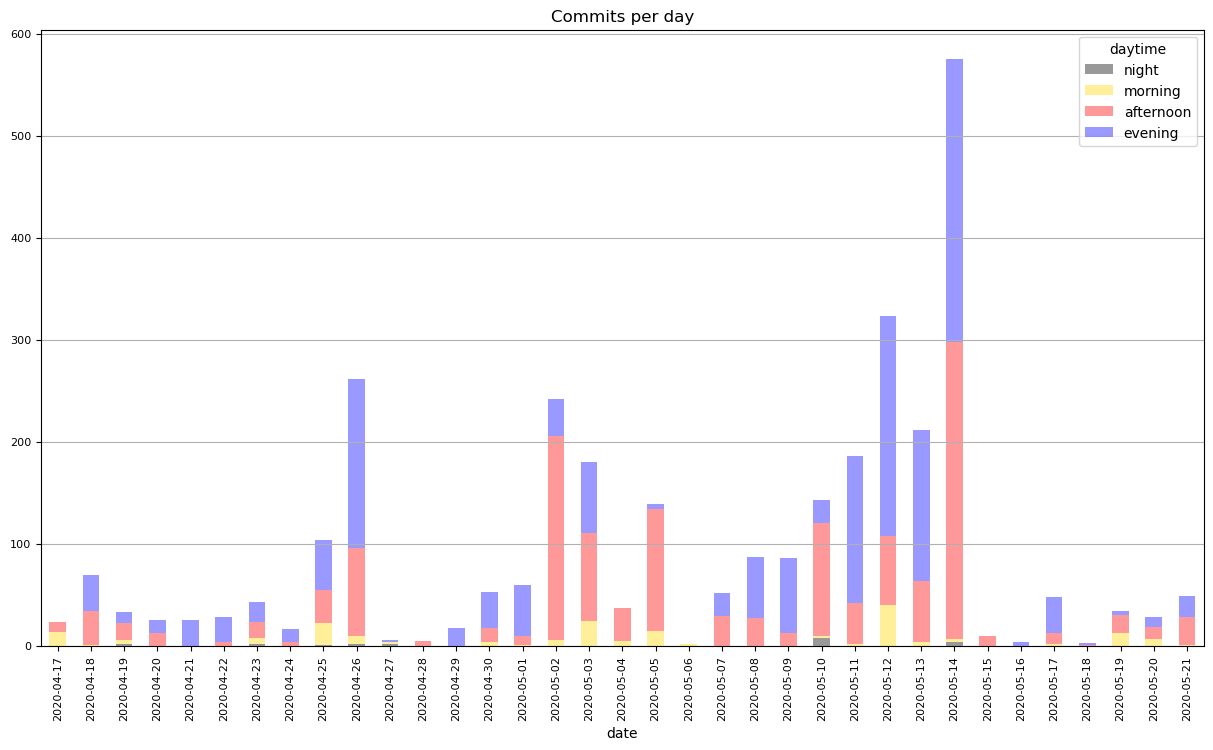

In [9]:
graph = res_df.plot.bar(
    figsize=(15, 8),
    fontsize=8,
    title="Commits per day",
    rot=90,
    alpha=0.4,
    stacked=True,
    color=("black", "gold", "red", "blue"))

graph.set_xlabel("date")
graph.grid(axis="y")


## Закроем подключение к базе данных

In [10]:
conn.close()

## Когда пользователи чаще всего делают коммиты: ночью, утром, днем или вечером?

In [11]:
print(res_df.sum())

daytime
night          21
morning       184
afternoon    1391
evening      1611
dtype: int64


### - вечером и днем

## В какой день:

- было больше всего коммитов
- и в то же время, количество коммитов вечером было больше чем днем?

In [12]:
print('Answer: ', res_df[res_df["evening"] > res_df["afternoon"]].sum(axis=1).idxmax())

Answer:  2020-05-12
